In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import drivers
from importlib import  reload
from lib import data_management as dm

In [3]:
# reload(drivers.Agilent_EXA)
from drivers.Agilent_EXA import *
from drivers.KeysightAWG import *
from drivers.Keysight_DSOX2014 import *
from drivers.E8257D import MXG, EXG
from drivers.Yokogawa_GS200 import Yokogawa_GS210
from scipy.fftpack import fft, fftshift

In [4]:
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

In [5]:
dso = Keysight_DSOX2014("DSO2014")

In [6]:
ro_awg = KeysightAWG("AWG2")

In [7]:
ro_lo = MXG("MXG")
current = Yokogawa_GS210("GS210_1")
q_lo = EXG("EXG")

In [8]:
q_awg=KeysightAWG("AWG3")

# Qubit setup

In [9]:
current.set_current(.2625e-3)
current.set_status(1)

True

# Continuous measurement 

## Define RO resonator

In [112]:
cal_ro_lo_freq = 6.62e9
if_freq = 50e6

calibrations = (dm.load_IQMX_calibration_database("TEST", -20))
cal_ro = calibrations.get(frozenset(dict(lo_power=15, ssb_power=-40, lo_frequency=cal_ro_lo_freq+if_freq, 
                                      if_frequency=if_freq, waveform_resolution=0.1).items()))
print(cal_ro)
pb = PulseBuilder(cal_ro)
pb.add_sine_pulse(1/if_freq*1e9, 0)
ro_awg.output_pulse_sequence(pb.build())

Calibration data for mixer TEST
Mixer parameters: {'mixer_id': 'TEST', 'iq_attenuation': -20}
Radiation parameters: {'lo_frequency': 6670000000.0, 'lo_power': 15, 'if_frequency': 50000000.0, 'ssb_power': -40, 'waveform_resolution': 0.1}
Optimization results: {'dc': -115.68116760253906, 'if': [-39.9294319152832, -95.4819564819336, -108.66310119628906]}
Optimization parameters {'dc_offsets': array([ 0.04645833, -0.36037525]), 'if_offsets': array([ 0.07385052, -0.37593333]), 'if_amplitudes': array([-4.58279975,  4.37595741]), 'if_phase': array([ 1.46597366])}
Optimization time: 0 h 1 m 18.61 s
Finished at: 2017-03-30 12:12:03.966428


In [113]:
dso.set_time_range(1e-6)

In [114]:
ro_resonator_frequency = 6.6213e9
span = 2e6
nop = 100
ro_lo_freqs = linspace(ro_resonator_frequency-span/2+if_freq, ro_resonator_frequency+span/2+if_freq, nop)

In [115]:
Is, Qs = [], []
dso.set_averages(2000)
for idx, freq in enumerate(ro_lo_freqs):
    ro_lo.set_frequency(freq)
    dso.digitize()
    times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
    Is.append(sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times)))
    Qs.append(sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times)))
    print("\r%.1f%%"%((idx+1)/len(ro_lo_freqs)*100), end="")
Is, Qs = array(Is), array(Qs)
amps = 20*log10(sqrt(Is**2+Qs**2))
phas = arctan2(Is, Qs)

100.0%

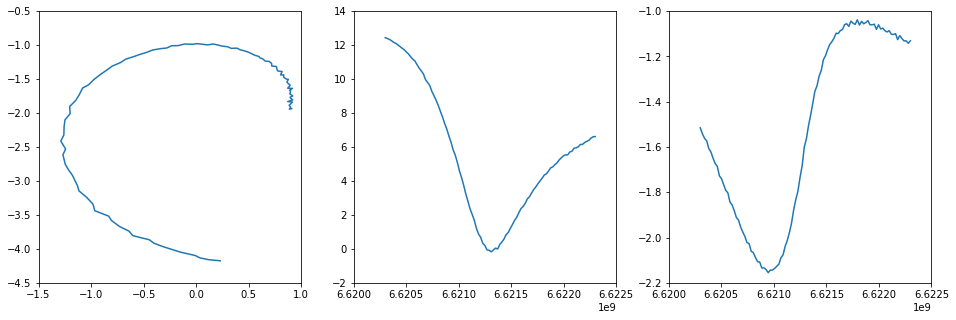

In [116]:
fig, axes = plt.subplots(1,3, figsize = (16,5))
axes[0].plot(Qs, Is)
axes[1].plot(ro_lo_freqs-if_freq, amps)
axes[2].plot(ro_lo_freqs-if_freq, unwrap(phas))

Extract the resonance frequency:

In [117]:
ro_freq = ro_lo_freqs[argmin(amps)]
ro_freq

6671310101.0101013

Check the value of the resonance frequency (should yield same amplitude and phase as in fig. above):

In [122]:
ro_lo.set_frequency(ro_freq)
dso.digitize()
times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
I = sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times))
Q = sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times))
print("Amplitude: %f"%(20*log10(sqrt(I**2+Q**2))))
print("Phase: %f"%arctan(I/Q))

Amplitude: -0.089566
Phase: 1.553066


## Two-tone spectroscopy (finding the qubit again)

Open the qubit's IQ mixer:

In [123]:
q_awg.output_continuous_wave(0,0,0, 3, channel=1)
q_awg.output_continuous_wave(0,0,0, 3, channel=2)
q_lo.set_output_state("OFF")
q_lo.set_power(15)

Make a sweep of the second tone near the qubit transition:

In [124]:
q_freq = 9.2e9
q_span = 50e6
q_lo_freqs = linspace(q_freq-q_span/2, q_freq+q_span/2, 1000)

In [125]:
ro_lo.set_frequency(ro_freq)

In [126]:
Is, Qs = [], []
dso.set_averages(10000)
for idx, freq in enumerate(q_lo_freqs):
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
    q_lo.set_frequency(freq)
    dso.digitize()
    times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
    Is.append(sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times)))
    Qs.append(sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times)))
Is, Qs = array(Is), array(Qs)

100.0%

In [153]:
ref_phases = []
dso.set_averages(10000)
for idx, freq in enumerate(q_lo_freqs):
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
    q_lo.set_frequency(freq)
    dso.digitize()
    times, channel_data = dso.get_data(Channel.THREE)
    spectrum = fft(channel_data)
    ref_phases.append(angle(spectrum[spectrum==max(spectrum)]))
ref_phases = array(ref_phases)

TypeError: 'int' object is not iterable

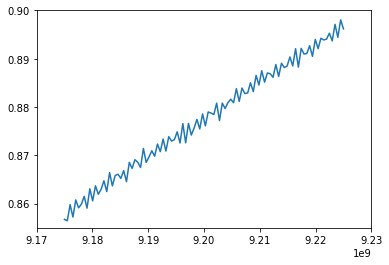

In [152]:
plt.plot(q_lo_freqs, ref_phases)

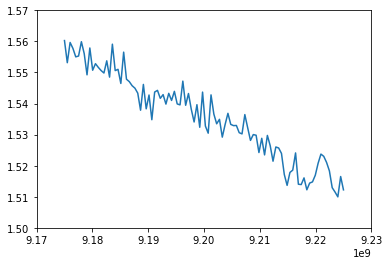

In [127]:
plt.plot(q_lo_freqs, arctan(Is/Qs))

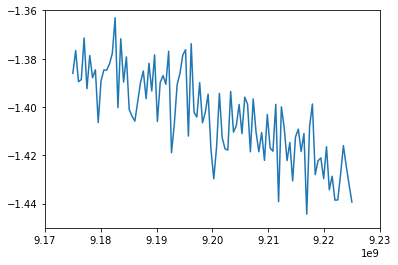

In [97]:
plt.plot(q_lo_freqs, arctan(Is/Qs))

# Pulsed readout

#### Qubit

In [32]:
q_frequency = 9.2e9

In [36]:
calibrations = (dm.load_IQMX_calibration_database("TESTQ", -6))
q_cal = calibrations.get(frozenset(dict(lo_power=15, ssb_power=-33, lo_frequency=q_frequency+if_freq, 
                                      if_frequency=if_freq, waveform_resolution=0.1).items()))
print(q_cal)

Calibration data for mixer TESTQ
Mixer parameters: {'mixer_id': 'TESTQ', 'iq_attenuation': -6}
Radiation parameters: {'lo_frequency': 9250000000.0, 'lo_power': 15, 'if_frequency': 50000000.0, 'ssb_power': -33, 'waveform_resolution': 0.1}
Optimization results: {'dc': -101.63865661621094, 'if': [-33.07297897338867, -88.72960662841797, -98.66692352294922]}
Optimization parameters {'dc_offsets': array([-0.07855484,  0.08620576]), 'if_offsets': array([-0.13549925,  0.06478032]), 'if_amplitudes': array([ 2.78881942,  3.10567976]), 'if_phase': array([ 1.68449273])}
Optimization time: 0 h 1 m 17.33 s
Finished at: 2017-03-30 12:40:16.092212


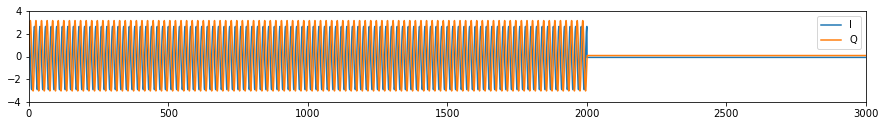

In [37]:
pb = PulseBuilder(q_cal)
pb.add_sine_pulse(2000, 0).add_zero_pulse(1000)
pulse_seq = pb.build()
pulse_seq.plot()
plt.gcf().set_size_inches(15,5/3)

In [38]:
q_lo.set_frequency(q_frequency+if_freq)
q_awg.output_pulse_sequence(pulse_seq)

#### Resonator 

Select the desired readout pulse length:

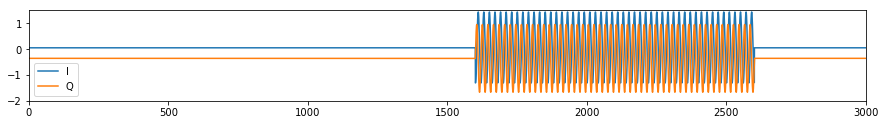

In [54]:
pb = PulseBuilder(cal_ro)
pb.add_zero_pulse(2000-400).add_sine_pulse(1000, 0).modulate_rectangle(1).add_zero_pulse(400)
pulse_seq = pb.build()
pulse_seq.plot()
plt.gcf().set_size_inches(15,5/3)

In [55]:
ro_awg.output_pulse_sequence(pulse_seq)

#### Aligning 

In [56]:
time_range = 10e-6
dso.set_time_range(time_range)
dso.set_time_offset(time_range/10+0e-9)

1e-06

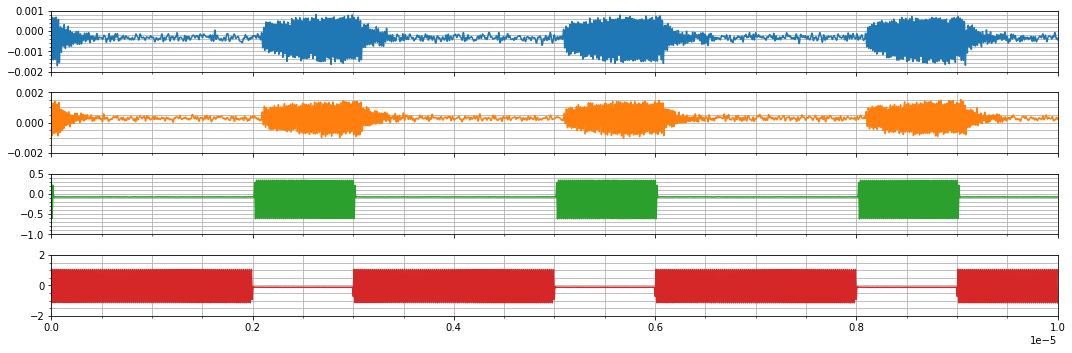

In [57]:
dso.digitize()
times, channel_data = dso.get_data(*Channel.ALL)
axes = flatten(plt.subplots(4,1, sharex=True, figsize=(15,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

Now choose correct time range and offset on the oscilloscope to correcly record pulse traces:

In [58]:
time_range = 1.1e-6
dso.set_time_range(time_range)
dso.set_time_offset(time_range/10+2000e-9)

2.11e-06

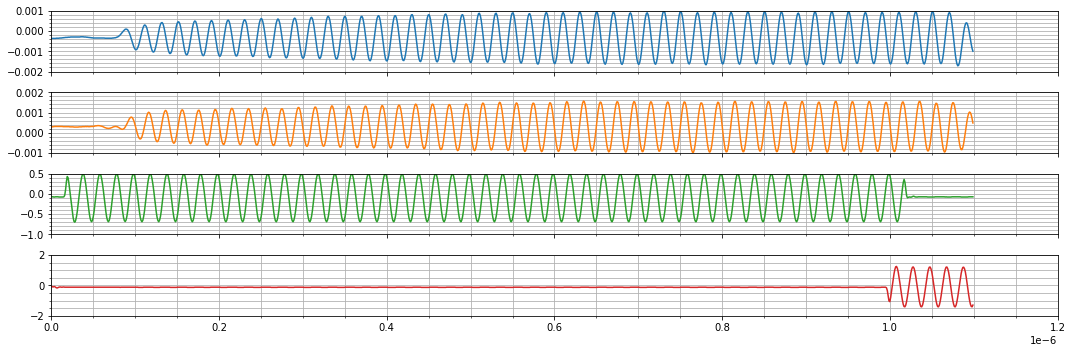

In [59]:
dso.set_averages(65536)
dso.digitize()
times, channel_data = dso.get_data(*Channel.ALL)
axes = flatten(plt.subplots(4,1, sharex=True, figsize=(15,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

Repeat the resonator characterization:

In [60]:
ro_resonator_frequency = 6.6213e9
span = 15e6
nop = 100
ro_lo_freqs = linspace(ro_resonator_frequency-span/2+if_freq, ro_resonator_frequency+span/2+if_freq, nop)

In [61]:
Is, Qs = [], []
dso.set_averages(2000)
for idx, freq in enumerate(ro_lo_freqs):
    ro_lo.set_frequency(freq)
    dso.digitize()
    times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
    Is.append(sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times)))
    Qs.append(sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times)))
    print("\r%.1f%%"%((idx+1)/len(ro_lo_freqs)*100), end="")
Is, Qs = array(Is), array(Qs)

100.0%

In [62]:
delay = 0
z_data = (Qs+1j*Is)*exp(2j*pi*(ro_lo_freqs-if_freq)*delay)
amps = 20*log10(abs(z_data))
phas = angle(z_data)

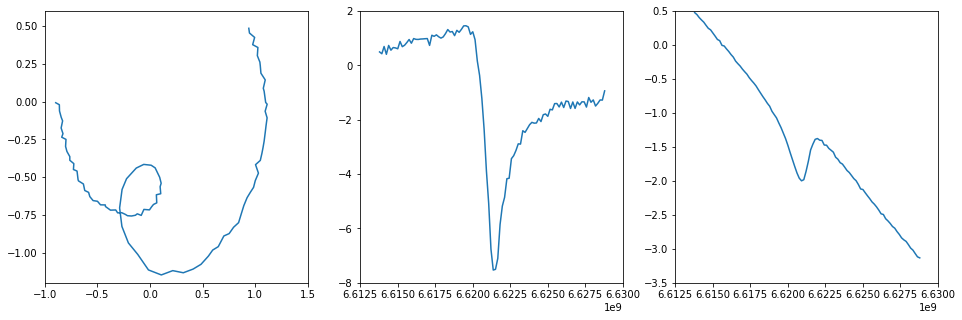

In [65]:
fig, axes = plt.subplots(1,3, figsize = (16,5))
axes[0].plot(real(z_data), imag(z_data))
axes[1].plot(ro_lo_freqs-if_freq, amps)
axes[2].plot(ro_lo_freqs-if_freq, unwrap(phas))
# axes[2].set_ylim(0.5, 1.6)

In [66]:
ro_freq = ro_lo_freqs[argmin(amps)]
ro_freq

6671375757.575758

Repeat the two-tone spectroscopy:

In [67]:
ro_lo.set_frequency(ro_freq)

In [68]:
q_freq = 9.20e9
q_span = 20e6
q_lo_freqs = linspace(q_freq-q_span/2+if_freq, q_freq+q_span/2+if_freq, 500)

In [69]:
q_lo.set_output_state("ON")

In [70]:
Is, Qs = [], []
dso.set_averages(2000)
for idx, freq in enumerate(q_lo_freqs):
    q_lo.set_frequency(freq)
    dso.digitize()
    times, channel_data = dso.get_data(Channel.ONE, Channel.TWO)
    Is.append(sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times)))
    Qs.append(sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times)))
    print("\r%.1f%%"%((idx+1)/len(q_lo_freqs)*100), end="")
Is, Qs = array(Is), array(Qs)

100.0%

In [71]:
z_data = (Qs+1j*Is)
amps = 20*log10(abs(z_data))
phas = angle(z_data)

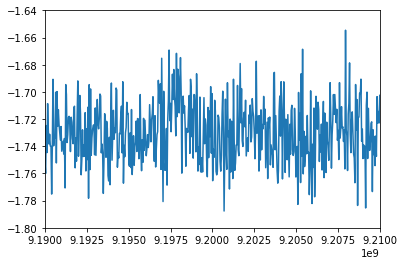

In [72]:
plt.plot(q_lo_freqs-if_freq, phas)

In [423]:
q_freq = q_lo_freqs[argmax(arctan(Is/Qs))]
q_freq

9199797979.7979794

In [22]:
pb = PulseBuilder(cal)

In [ ]:
cal_q_lo_freq = 9.223e9
calibrations = (dm.load_IQMX_calibration_database("TESTQ", -20))
cal = calibrations.get(frozenset(dict(lo_power=15, ssb_power=-40, lo_frequency=cal_q_lo_freq+if_freq, 
                                      if_frequency=if_freq, waveform_resolution=0.1).items()))
print(cal)
pb.add_sine_pulse(100, 0)
q_awg.output_pulse_sequence(pb.build())

In [33]:
pulse = pb.add_sine_pulse(1000, 0).modulate_gauss(0.5,20).add_zero_pulse(100)\
                .add_sine_pulse(50, pi/2).modulate_rectangle(0.3).add_zero_pulse(100).build()
for i in range(1):
    pb = pb.add_sine_pulse(200,0).add_zero_pulse(0)
#     pb = pb.add_sine_pulse(1000,0).modulate_hamming().add_zero_pulse(1000)
#     pb = pb.add_sine_pulse(1000,0).modulate_gauss(1, 250).add_zero_pulse(1000)
#      pb = pb.add_sine_pulse(1000,0).modulate_chebwin(100).add_zero_pulse(1000)
#     pb = pb.add_sine_pulse(100,0)

pulse = pb.build()

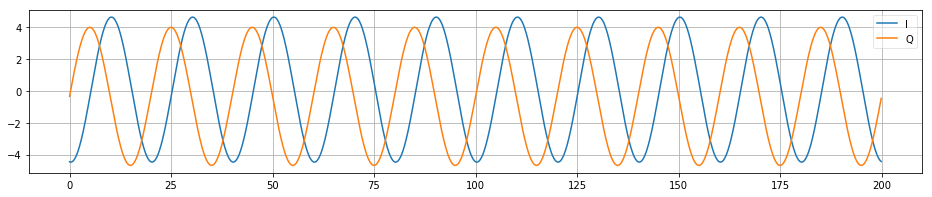

In [34]:
pulse.plot(marker="")
plt.legend(framealpha=0.5)
plt.grid()
plt.gcf().set_size_inches(16,3)
# plt.xlim(0,10)

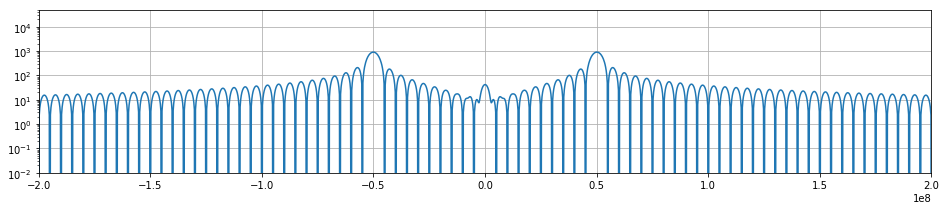

In [27]:
N = len(pulse.get_I_waveform())*10
plot(fftshift(fftfreq(N, 0.1e-9)), abs(fftshift(fft(pulse.get_I_waveform(), n=N))), marker="")
plt.xlim(-200e6,200e6)
plt.yscale("log")
plt.ylim(1e-2, 5e4)
plt.gcf().set_size_inches(16,3)
plt.grid()

In [35]:
ro_awg.output_pulse_sequence(pulse)

In [13]:
awg.set_outp2_compl(1)

True

## Reading out

In [13]:
Channel.ALL[0].value

'CHAN1'

In [58]:
dso.set_time_range(2e-6)
dso.set_time_offset(150e-9)
# dso.set_offset(0, *Channel.ALL)

1.5e-07

In [59]:
dso.set_averages(10000)

True

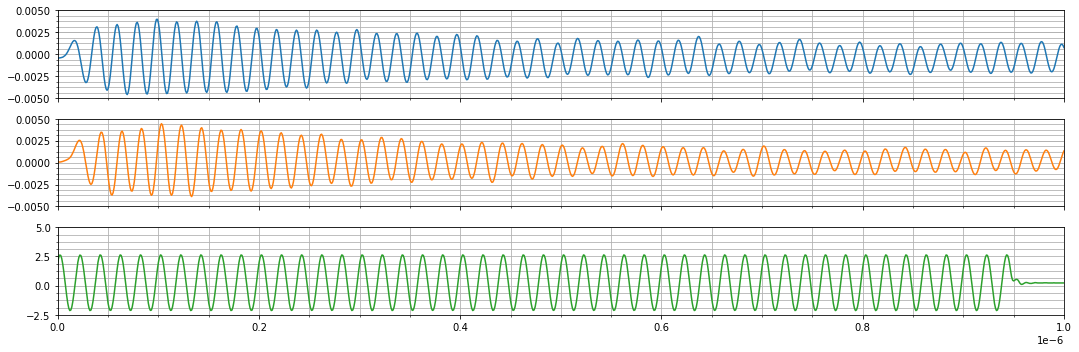

In [90]:
dso.digitize()
times, channel_data = dso.get_data(*Channel.ALL)
axes = flatten(plt.subplots(3,1, sharex=True, figsize=(15,5))[1])
colors = ["C0", "C1", "C2", "C3"]
for idx, ax in enumerate(axes):
    ax.plot(times, channel_data[idx], color=colors[idx])
    ax.minorticks_on()
    ax.grid(which="both")
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()

In [23]:
I = sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times))
Q = sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times))
I,Q

NameError: name 'if_freq' is not defined

### IQ clouds

In [ ]:
import 

In [243]:
dso.set_averages(1)

True

In [256]:
Is2, Qs2 = [], []
for i in range(100):
    dso.digitize()
    times, channel_data = dso.get_data(Channel.THREE, Channel.FOUR)
    I = sum(channel_data[0]*cos(2*pi*if_freq*times) + channel_data[1]*sin(2*pi*if_freq*times))
    Q = sum(channel_data[1]*cos(2*pi*if_freq*times) - channel_data[0]*sin(2*pi*if_freq*times))
    Is2.append(I)
    Qs2.append(Q)

In [265]:
Is_noise = array(Is)+np.random.normal(size=100)
Qs_noise = array(Qs)+np.random.normal(size=100)
Is2_noise = array(Is2)+np.random.normal(size=100)
Qs2_noise = array(Qs2)+np.random.normal(size=100)

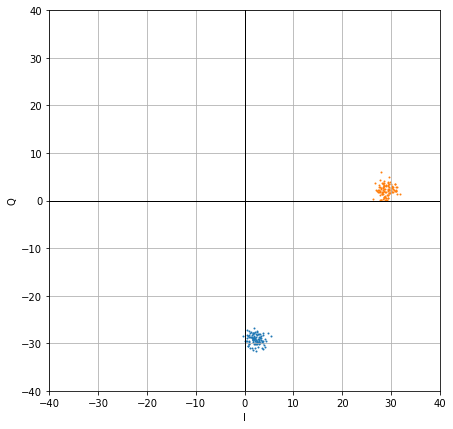

In [272]:
plt.scatter(Is_noise, Qs_noise, s=1)
plt.scatter(Is2_noise, Qs2_noise, s=1)
plt.plot([-40, 40], [0, 0], color="black", linewidth=1)
plt.plot([0, 0], [-40, 40], color="black", linewidth=1)

plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.gcf().set_size_inches(7,7)
ax = plt.gca()
plt.grid()

ax.set_xlabel("I")
ax.set_ylabel("Q")

In [144]:
sqrt(I**2+Q**2)

0.3139547744073401

In [8]:
mxg.get_frequency()

7116340000.0

In [58]:
amplitudes = []
dso.set_averages(200)
freqs = linspace(7.604e9, 7.606e9, 100)
for frequency in freqs:
    mxg.set_frequency(frequency)
    dso.digitize()
    signal = dso.get_data(Channel.FOUR)[1]
    amplitudes.append((max(signal)-min(signal))/2)

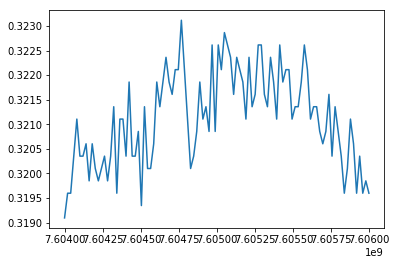

In [59]:
plt.plot(freqs, amplitudes)